# CH04.4. **Bidirectional Sequence Model**

#### [][][][][]

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 100
USE_PRETRAIN_YN = 'N'
MODEL_PTH = '../../model/mnistBiSeq.pt'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import random
import tqdm
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import torch
import torchvision
import torchinfo

#(2) Set up options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
torch.mps.manual_seed(seed=SEED_NUM)

#(3) Set up device
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

>> Device : mps


#### 00.2. **사용자정의함수 정의**

In [3]:
#(1) Define `show_img()` function
def show_img(df:torchvision.datasets, index:int) :
    img = df[index][0]
    target = df[index][1]
    img = img / 2 + 0.5    
    plt.imshow(X=img) 
    plt.xlabel(xlabel=f'Target : {target}({df.classes[target]})')
    plt.show()

#(2) Define `compute_metrics()` function
def compute_metrics(model:torch.nn.Module, loader:torch.utils.data.DataLoader) :
    _preds = []
    _targets = []
    model.eval()
    with torch.no_grad() : 
        for inputs, targets in loader :
            preds = model(x=inputs)
            preds = torch.argmax(input=preds, dim=1)
            _preds.extend(preds.cpu().numpy())
            _targets.extend(targets.cpu().numpy())
    model.train()
    accuracy = sklearn.metrics.accuracy_score(y_true=_targets, y_pred=_preds)
    precision = sklearn.metrics.precision_score(y_true=_targets, y_pred=_preds, average='weighted')
    recall = sklearn.metrics.recall_score(y_true=_targets, y_pred=_preds, average='weighted')
    f1 = sklearn.metrics.f1_score(y_true=_targets, y_pred=_preds, average='weighted')
    output = pd.DataFrame(data={
        'metricName' : ['accuracy', 'precision', 'recall', 'f1'], 
        'value'      : [accuracy, precision, recall, f1] 
    })
    return output

#### 00.3. **클래스 정의**

In [4]:
#(1) Define `MyClassificationModel` class
class MyClassificationModel(torch.nn.Module) :
    def __init__(self, input_size:int, hidden_size:int, seq_len:int, layers_num:int, class_num:int, device:torch.device) :
        super().__init__()
        self.hidden_size = hidden_size
        self.seq_len = seq_len
        self.layers_num = layers_num
        self.device = device
        self.layers = torch.nn.ModuleDict()
        self.layers['lstm'] = torch.nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=layers_num, 
            batch_first=True,
            bidirectional=True
        )
        self.layers['fc'] = torch.nn.Linear(in_features=hidden_size*seq_len*2, out_features=class_num)
        self.to(device=self.device)
    def forward(self, x:torch.Tensor) :
        h0 = torch.zeros(size=(self.layers_num*2, x.size()[0], self.hidden_size), device=self.device)
        c0 = torch.zeros(size=(self.layers_num*2, x.size()[0], self.hidden_size), device=self.device)
        x = x.to(device=self.device)
        x = self.layers['lstm'](x, (h0, c0))[0]
        x = x.reshape(shape=(x.shape[0], self.seq_len*self.hidden_size*2))
        x = self.layers['fc'](x)
        return x

<b></b>

## 01. **데이터셋 전처리 및 로드**

#### 01.1. **이미지 전처리 파이프라인 정의**

In [5]:
img_tf = torchvision.transforms.Compose(
    transforms=[
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: x.squeeze(0))
    ]
)

#### 01.2. **데이터셋 로드**

In [6]:
mnist_train = torchvision.datasets.MNIST(root='../../data', train=True, download=True, transform=img_tf)
mnist_test = torchvision.datasets.MNIST(root='../../data', train=False, download=True, transform=img_tf)

#### 01.3. **EDA**

In [7]:
#(1) Print sample of train
len(mnist_train)

60000

In [8]:
#(2) Print image shape 
mnist_train[0][0].shape

torch.Size([28, 28])

In [9]:
#(3) Print frequency of target class
target_freq = collections.Counter()
for i in range(len(mnist_train)):
    input, target = mnist_train[i]
    if isinstance(target, torch.Tensor) :
        target = target.item()
    target_freq[target] += 1
pd.DataFrame(data=list(target_freq.items()), columns=['class', 'count']).sort_values(by='class')

,class,count
1,0,5923
3,1,6742
5,2,5958
6,3,6131
2,4,5842
0,5,5421
7,6,5918
8,7,6265
9,8,5851
4,9,5949


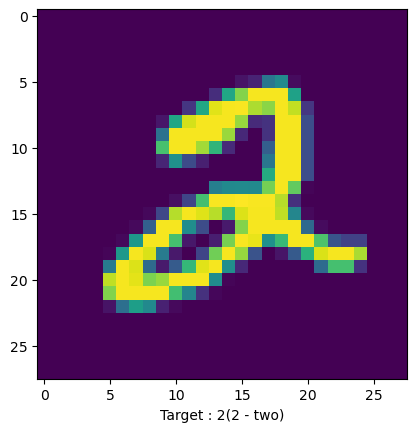

In [10]:
#(4) Display image
show_img(df=mnist_train, index=5)

#### 01.4. **데이터로더 변환**

In [11]:
mnist_train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=BATCH_SIZE, shuffle=True)
mnist_test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 02. **모델 구축 및 학습**

#### 02.1. **모델 정의**

In [12]:
#(1) Define hyper-parameter
seq_len = mnist_train[0][0].shape[0]
input_size = mnist_train[0][0].shape[1]
layers_num = 2
hidden_size = 12
class_num = 10

In [13]:
#(2) Define `model`
model = MyClassificationModel(
    input_size=input_size, 
    hidden_size=hidden_size, 
    seq_len=seq_len, 
    layers_num=layers_num,
    class_num=class_num,
    device=device
).to(dtype=torch.float32)

#(3) Display `model`
model

MyClassificationModel(
  (layers): ModuleDict(
    (lstm): LSTM(28, 12, num_layers=2, batch_first=True, bidirectional=True)
    (fc): Linear(in_features=672, out_features=10, bias=True)
  )
)

In [14]:
#(4)
dummy = torch.randn(size=[BATCH_SIZE]+list(mnist_train[0][0].squeeze(dim=0).shape)).to(device=device)
torchinfo.summary(model=model, input_data=dummy)

Layer (type:depth-idx)                   Output Shape              Param #
MyClassificationModel                    [32, 10]                  --
├─ModuleDict: 1-1                        --                        --
│    └─LSTM: 2-1                         [32, 28, 24]              7,680
│    └─Linear: 2-2                       [32, 10]                  6,730
Total params: 14,410
Trainable params: 14,410
Non-trainable params: 0
Total mult-adds (M): 7.10
Input size (MB): 0.10
Forward/backward pass size (MB): 0.17
Params size (MB): 0.06
Estimated Total Size (MB): 0.33

In [15]:
#(5) Define loss function
criterion = torch.nn.CrossEntropyLoss()

#(6) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-7)

#(7) Define Scheduler
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#### 02.2. **모델 체크포인트 로드**

In [16]:
if USE_PRETRAIN_YN == 'Y' :
    checkpoint = torch.load(f=MODEL_PTH)
    model.load_state_dict(state_dict=checkpoint['model'])
    optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = loss_hist[-1]
else :
    epoch = 0
    loss_hist = []
    best_loss = float('inf')
print(f">> Epoch={epoch}, Train Loss={best_loss}")

>> Epoch=0, Train Loss=inf


#### 02.3. **모델 학습**

In [ ]:
batch_len = len(mnist_train_loader)
progress_bar = tqdm.trange(epoch, EPOCH_NUM)
for epoch in progress_bar : 
    running_loss = 0.0
    model.train()
    for inputs, targets in mnist_train_loader :
        optimizer.zero_grad() 
        preds = model(x=inputs)
        loss = criterion(input=preds, target=targets.to(device=device))
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss_avg = running_loss / batch_len
    loss_hist.append(running_loss_avg)
    if running_loss_avg < best_loss :
        best_loss = running_loss_avg
        torch.save(
            obj={
                'epoch'     : epoch,
                'loss_hist' : loss_hist,
                'model'     : model.state_dict(),
                'optimizer' : optimizer.state_dict()
            }, 
            f=MODEL_PTH
        )
    # scheduler.step()
    progress_bar.set_postfix(ordered_dict={'epoch':epoch+1, 'loss':running_loss_avg}) 

 15%|█▌        | 15/100 [07:53<44:22, 31.33s/it, epoch=15, loss=0.031] 

<b></b>

## 03. **모델 평가**

#### 03.1. **최적 성능 모델 로드**

In [ ]:
checkpoint = torch.load(f=MODEL_PTH)
model.load_state_dict(state_dict=checkpoint['model'])
print(f'>> Epoch : {checkpoint["epoch"]}, Loss : {checkpoint["loss_hist"][-1]}')

#### 03.2. **과소 적합 확인**

In [ ]:
#(1) Plot traing loss
plt.figure(figsize=(12, 6))
plt.title(label='Training Loss')
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist)
plt.show()

In [ ]:
#(2) Check metrics
compute_metrics(model=model, loader=mnist_train_loader)

#### 03.3. **일반화 성능 평가**

In [ ]:
compute_metrics(model=model, loader=mnist_test_loader)